<a href="https://colab.research.google.com/github/JHyunjun/AnomalyDetection/blob/main/240827_TS_DL_Ensemble_517.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:
# # TensorFlow 버전 출력
# print("TensorFlow 버전:", tf.__version__)

# # 사용 가능한 GPU 목록 확인
# gpus = tf.config.list_physical_devices('GPU')
# print("사용 가능한 GPU:", gpus)

# if gpus:
#     # GPU가 감지되면 간단한 연산 수행
#     with tf.device('/GPU:0'):
#         a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
#         b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
#         c = tf.matmul(a, b)
#         print("GPU에서 수행된 행렬 곱셈 결과:")
#         print(c)
# else:
#     print("GPU를 찾을 수 없습니다. CPU에서 실행됩니다.")

# # 현재 사용 중인 장치 확인
# print("현재 사용 중인 장치:", tf.test.gpu_device_name())

# # GPU 사용 가능 여부 확인
# print("GPU 사용 가능:", tf.test.is_built_with_cuda())

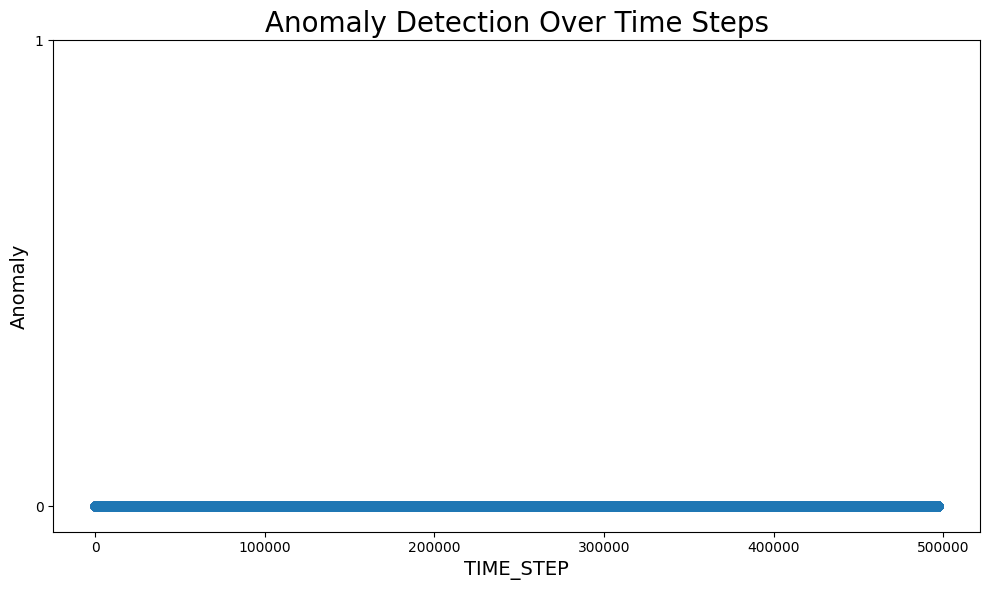

Total data points: 496800
Number of anomalies: 0
Anomaly ratio: 0.00%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
TRAIN_DF_RAW = pd.read_csv("C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_2408/open/train/train.csv")
TEST_DF_RAW = pd.read_csv("C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_2408/open/test/test.csv")
# TRAIN_DF_RAW = TRAIN_DF_RAW[84999:]

COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop(["Timestamp", 'anomaly'])

# TIME_STEP 열 추가 (0부터 시작하는 인덱스)
TRAIN_DF_RAW['TIME_STEP'] = range(len(TRAIN_DF_RAW))

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(TRAIN_DF_RAW['TIME_STEP'], TRAIN_DF_RAW['anomaly'], alpha=0.5)

plt.title('Anomaly Detection Over Time Steps', fontsize=20)
plt.xlabel('TIME_STEP', fontsize=14)
plt.ylabel('Anomaly', fontsize=14)
plt.yticks([0, 1])

plt.tight_layout()
plt.show()

# 통계 정보 출력
anomaly_count = TRAIN_DF_RAW['anomaly'].sum()
total_count = len(TRAIN_DF_RAW)
print(f"Total data points: {total_count}")
print(f"Number of anomalies: {anomaly_count}")
print(f"Anomaly ratio: {anomaly_count/total_count*100:.2f}%")

In [ ]:
# 정규화 과정
TRN_MIN = TRAIN_DF_RAW[COLUMNS_IN_TRAIN_DATASET].min()
TRN_MAX = TRAIN_DF_RAW[COLUMNS_IN_TRAIN_DATASET].max()

def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TRN_MAX[c] != TRN_MIN[c]:
            ndf[c] = (df[c] - TRN_MIN[c]) / (TRN_MAX[c] - TRN_MIN[c])
    return ndf

TRAIN_DF = normalize(TRAIN_DF_RAW[COLUMNS_IN_TRAIN_DATASET])
TEST_DF = normalize(TEST_DF_RAW[COLUMNS_IN_TRAIN_DATASET])

print("TRAIN_DF.shape : ", TRAIN_DF.shape)
print("TEST_DF.shape : ", TEST_DF.shape )

TRAIN_DF.shape :  (496800, 51)
TEST_DF.shape :  (450000, 51)


In [ ]:
def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i+window_size])
    return np.array(windows)

# TRAIN_DF를 윈도우로 나누기
window_size = 10
train_windows = create_windows(TRAIN_DF.values, window_size)

print("Original TRAIN_DF shape:", TRAIN_DF.shape)
print("After windowing, train_windows shape:", train_windows.shape)

# TEST_DF도 같은 방식으로 윈도우로 나누기
test_windows = create_windows(TEST_DF.values, window_size)

print("\nOriginal TEST_DF shape:", TEST_DF.shape)
print("After windowing, test_windows shape:", test_windows.shape)

Original TRAIN_DF shape: (496800, 51)
After windowing, train_windows shape: (496791, 10, 51)

Original TEST_DF shape: (450000, 51)
After windowing, test_windows shape: (449991, 10, 51)


In [ ]:
import numpy as np
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 준비
train_windows = create_windows(TRAIN_DF.values, window_size)
test_windows = create_windows(TEST_DF.values, window_size)

# 데이터 정규화
scaler = StandardScaler()
train_windows_flat = train_windows.reshape(-1, train_windows.shape[-1])
train_windows_scaled = scaler.fit_transform(train_windows_flat).reshape(train_windows.shape)
test_windows_scaled = scaler.transform(test_windows.reshape(-1, test_windows.shape[-1])).reshape(test_windows.shape)

# 학습 데이터와 검증 데이터 분리
train_data, val_data = train_test_split(train_windows_scaled, test_size=0.1, random_state=42)

# 1D-CNN Autoencoder 모델 정의
def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(64, 7, activation='relu', padding='same'),
        layers.MaxPooling1D(2, padding='same'),
        layers.Conv1D(32, 5, activation='relu', padding='same'),
        layers.Conv1D(16, 3, activation='relu', padding='same'),
        layers.Conv1D(32, 3, activation='relu', padding='same'),
        layers.UpSampling1D(2),
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.Conv1D(input_shape[-1], 3, activation=None, padding='same')
    ])
    return model

# LSTM Autoencoder 모델 정의
def create_lstm_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32, return_sequences=True),
        layers.LSTM(16, return_sequences=True),
        layers.LSTM(32, return_sequences=True),
        layers.LSTM(64, return_sequences=True),
        layers.TimeDistributed(layers.Dense(input_shape[-1]))
    ])
    return model

# GRU Autoencoder 모델 정의
def create_gru_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(64, return_sequences=True),
        layers.GRU(32, return_sequences=True),
        layers.GRU(16, return_sequences=True),
        layers.GRU(16, return_sequences=True),
        layers.GRU(32, return_sequences=True),
        layers.GRU(64, return_sequences=True),
        layers.TimeDistributed(layers.Dense(input_shape[-1]))
    ])
    return model

# 앙상블 모델 생성
def create_ensemble_model(input_shape):
    cnn_model = create_cnn_model(input_shape)
    lstm_model = create_lstm_model(input_shape)
    gru_model = create_gru_model(input_shape)

    inputs = layers.Input(shape=input_shape)
    cnn_output = cnn_model(inputs)
    lstm_output = lstm_model(inputs)
    gru_output = gru_model(inputs)

    # 세 모델의 출력을 평균내어 최종 출력 생성
    ensemble_output = layers.Average()([cnn_output, lstm_output, gru_output])

    model = models.Model(inputs=inputs, outputs=ensemble_output)
    return model

# 모델 생성 및 컴파일
model = create_ensemble_model(train_data.shape[1:])
model.compile(optimizer='adam', loss='mse')

# 모델 요약 출력
model.summary()

# Early stopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    train_data, train_data,
    epochs=10,
    batch_size=64,
    validation_data=(val_data, val_data),
    shuffle=True,
    callbacks=[early_stopping]
)

# history 출력
print(history.history)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 10, 51)]     0           []                               
                                                                                                  
 sequential_9 (Sequential)      (None, 10, 51)       52355       ['input_16[0][0]']               
                                                                                                  
 sequential_10 (Sequential)     (None, 10, 51)       79667       ['input_16[0][0]']               
                                                                                                  
 sequential_11 (Sequential)     (None, 10, 51)       62835       ['input_16[0][0]']               
                                                                                            

In [ ]:
model.save('C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_AD_2408/modelsave/240828/240825Orig_DeepModel.h5')
print("모델이 'ensemble_autoencoder_model.h5' 파일로 저장되었습니다.")

14063/14063 [==============================] - 156s 11ms/step


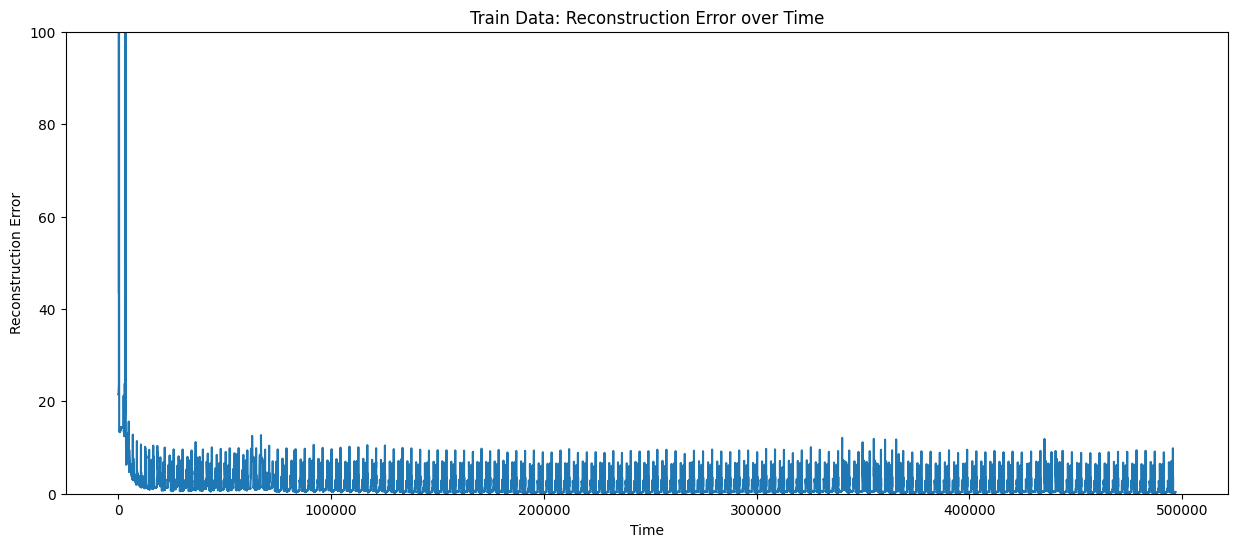

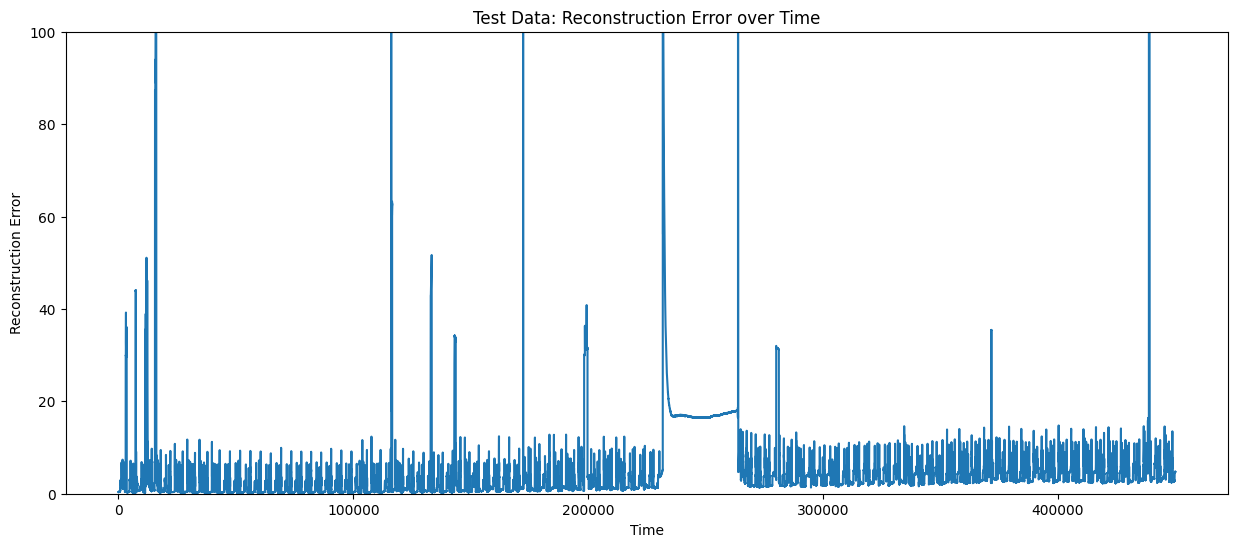

플로팅이 완료되었습니다. 그래프를 확인해주세요.
Train 데이터 Reconstruction Error - 평균: 1.2307, 최소값: 0.0758, 최대값: 179.4216
Test 데이터 Reconstruction Error - 평균: 52.7345, 최소값: 0.1335, 최대값: 361103.6432


In [ ]:
with tf.device('/CPU:0'):
    train_pred = model.predict(train_windows, batch_size = 32)
    test_pred = model.predict(test_windows, batch_size = 32)

train_mse = np.mean(np.square(train_windows_scaled - train_pred), axis=(1,2))
test_mse = np.mean(np.square(test_windows_scaled - test_pred), axis=(1,2))


# Train 데이터 플로팅
plt.figure(figsize=(15, 6))
plt.plot(TRAIN_DF.index[window_size-1:], train_mse)
plt.title('Train Data: Reconstruction Error over Time')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
mean_train = np.mean(train_mse)
plt.ylim(0,100)
plt.grid(True)
plt.show()

# Test 데이터 플로팅
plt.figure(figsize=(15, 6))
plt.plot(TEST_DF.index[window_size-1:], test_mse)
plt.title('Test Data: Reconstruction Error over Time')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
mean_test = np.mean(test_mse)
plt.ylim(0,100)
plt.grid(True)
plt.show()

print("플로팅이 완료되었습니다. 그래프를 확인해주세요.")
print(f"Train 데이터 Reconstruction Error - 평균: {mean_train:.4f}, 최소값: {np.min(train_mse):.4f}, 최대값: {np.max(train_mse):.4f}")
print(f"Test 데이터 Reconstruction Error - 평균: {mean_test:.4f}, 최소값: {np.min(test_mse):.4f}, 최대값: {np.max(test_mse):.4f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

with tf.device('/CPU:0'):
    train_pred = model.predict(train_windows)
    test_pred = model.predict(test_windows)

train_mse = np.mean(np.square(train_windows_scaled - train_pred), axis=(1,2))
test_mse = np.mean(np.square(test_windows_scaled - test_pred), axis=(1,2))

# 버전 1: y축 범위를 평균 ±5로 설정
def plot_mean_range(data, mse, title):
    plt.figure(figsize=(15, 6))
    plt.plot(data.index[window_size-1:], mse)
    plt.title(f'{title}: Reconstruction Error over Time (Mean ±5 Range)')
    plt.xlabel('Time')
    plt.ylabel('Reconstruction Error')
    mean_mse = np.mean(mse)
    # plt.ylim(max(0, mean_mse - 2), mean_mse + 2)
    plt.ylim(0,10)
    plt.show()
    plt.grid(True)

# 버전 2: y축 범위를 0에서 100으로 고정
def plot_fixed_range(data, mse, title):
    plt.figure(figsize=(15, 6))
    plt.plot(data.index[window_size-1:], mse)
    plt.title(f'{title}: Reconstruction Error over Time (Fixed 0-100 Range)')
    plt.xlabel('Time')
    plt.ylabel('Reconstruction Error')
    mean_mse = np.mean(mse)
    # plt.ylim(max(0, mean_mse - 2), mean_mse + 2)
    plt.ylim(0,20)
    plt.show()
    plt.grid(True)

# Train 데이터 플로팅
plot_mean_range(TRAIN_DF, train_mse, 'Train Data')
plot_fixed_range(TRAIN_DF, train_mse, 'Train Data')

# Test 데이터 플로팅
plot_mean_range(TEST_DF, test_mse, 'Test Data')
plot_fixed_range(TEST_DF, test_mse, 'Test Data')

print("플로팅이 완료되었습니다. 총 4개의 그래프를 확인해주세요.")
print(f"Train 데이터 Reconstruction Error - 평균: {np.mean(train_mse):.4f}, 최소값: {np.min(train_mse):.4f}, 최대값: {np.max(train_mse):.4f}")
print(f"Test 데이터 Reconstruction Error - 평균: {np.mean(test_mse):.4f}, 최소값: {np.min(test_mse):.4f}, 최대값: {np.max(test_mse):.4f}")

15450/15525 [============================>.] - ETA: 0s

In [ ]:
import numpy as np
import pandas as pd

# 원본 TEST 데이터 로드
TEST_DF_RAW = pd.read_csv("C:/Users/limit/OneDrive/Desktop/Deep Learning/Daycon_2408/open/test/test.csv")

# test_mse가 이미 계산되어 있다고 가정합니다.
# 만약 test_mse가 없다면, 여기에 test_mse를 계산하는 코드를 추가해야 합니다.

# Window 크기 설정
WINDOW_SIZE = window_size

# 제출용 데이터프레임 초기화 (모든 값을 0으로 설정)
submission_df = pd.DataFrame({
    'Timestamp': TEST_DF_RAW['Timestamp'],
    'anomaly': 0
})

# 10번째 데이터부터 모델의 예측 결과 적용
# test_mse의 길이가 TEST_DF_RAW보다 WINDOW_SIZE - 1만큼 짧다고 가정합니다.
anomaly_mask = test_mse >= 15
submission_df.loc[WINDOW_SIZE-1:, 'anomaly'] = np.where(anomaly_mask, 1, 0)

# CSV 파일로 저장
submission_df.to_csv('sample_submission.csv', index=False)

print("제출 파일이 생성되었습니다: sample_submission.csv")

# 결과 요약
anomaly_count = np.sum(submission_df['anomaly'])
print(f"\n총 데이터 포인트 수: {len(TEST_DF_RAW)}")
print(f"이상 탐지된 데이터 포인트 수: {anomaly_count}")
print(f"정상으로 판단된 데이터 포인트 수: {len(TEST_DF_RAW) - anomaly_count}")

# 처음 몇 개의 행 출력
print("\n제출 파일의 처음 15개 행:")
print(submission_df.head(15))

# 마지막 몇 개의 행 출력
print("\n제출 파일의 마지막 5개 행:")
print(submission_df.tail())

제출 파일이 생성되었습니다: sample_submission.csv

총 데이터 포인트 수: 450000
이상 탐지된 데이터 포인트 수: 39564
정상으로 판단된 데이터 포인트 수: 410436

제출 파일의 처음 15개 행:
              Timestamp  anomaly
0   2024-08-01 11:00:00        0
1   2024-08-01 11:00:01        0
2   2024-08-01 11:00:02        0
3   2024-08-01 11:00:03        0
4   2024-08-01 11:00:04        0
5   2024-08-01 11:00:05        0
6   2024-08-01 11:00:06        0
7   2024-08-01 11:00:07        0
8   2024-08-01 11:00:08        0
9   2024-08-01 11:00:09        0
10  2024-08-01 11:00:10        0
11  2024-08-01 11:00:11        0
12  2024-08-01 11:00:12        0
13  2024-08-01 11:00:13        0
14  2024-08-01 11:00:14        0

제출 파일의 마지막 5개 행:
                  Timestamp  anomaly
449995  2024-08-06 15:59:55        0
449996  2024-08-06 15:59:56        0
449997  2024-08-06 15:59:57        0
449998  2024-08-06 15:59:58        0
449999  2024-08-06 15:59:59        0


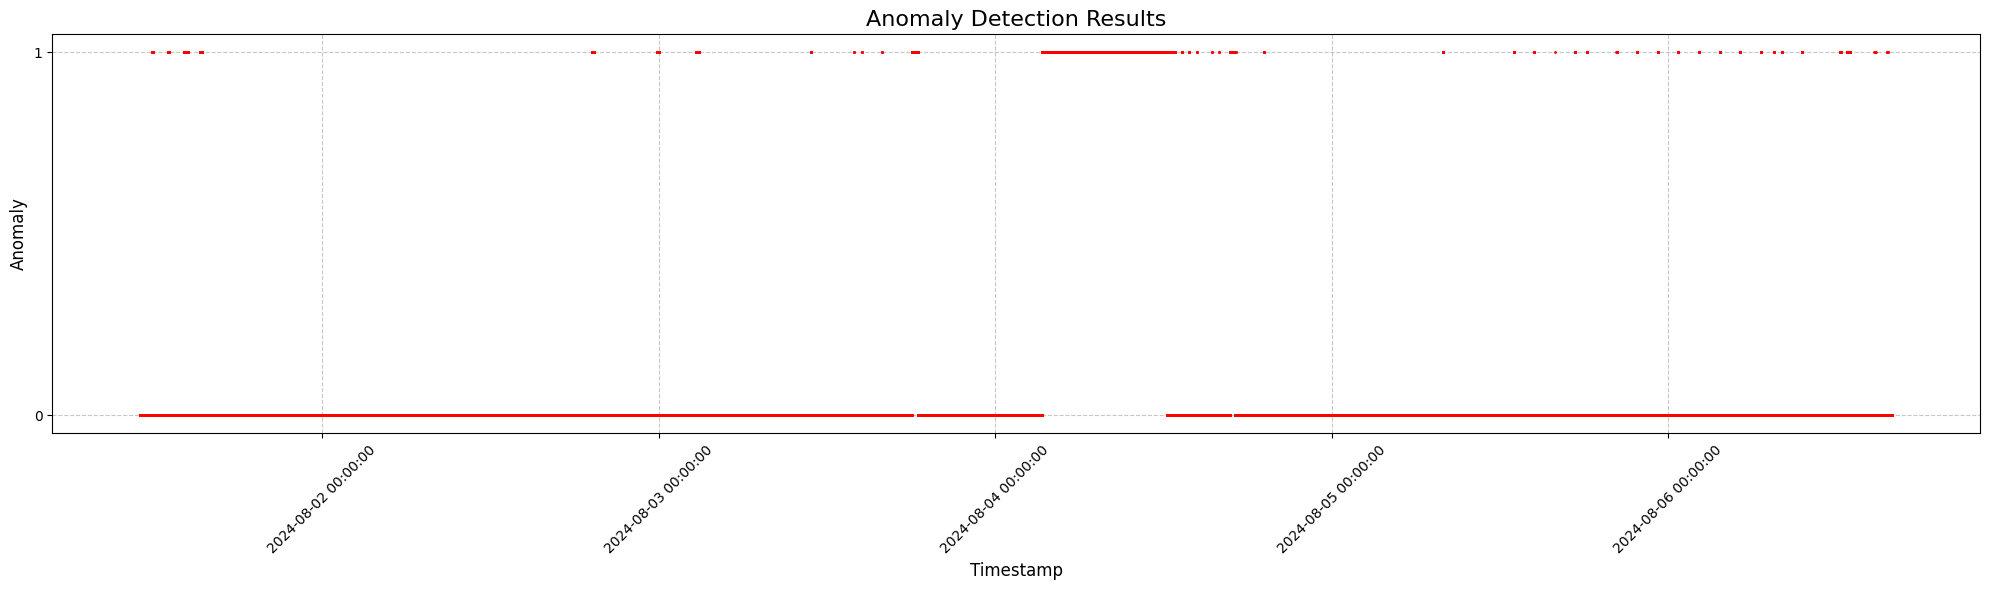

그래프가 'anomaly_detection_results.png' 파일로 저장되었습니다.

총 데이터 포인트 수: 450000
이상 탐지된 데이터 포인트 수: 39564
정상으로 판단된 데이터 포인트 수: 410436
이상 탐지 비율: 8.79%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# 제출 파일 로드 (이미 생성되어 있다고 가정)
submission_df = pd.read_csv('sample_submission.csv')

# Timestamp를 datetime으로 변환
submission_df['Timestamp'] = pd.to_datetime(submission_df['Timestamp'])

# 그래프 설정
plt.figure(figsize=(20, 6))
plt.plot(submission_df['Timestamp'], submission_df['anomaly'], 'r.', markersize=2)

# x축 설정
plt.xlabel('Timestamp', fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M:%S'))

# y축 설정
plt.ylabel('Anomaly', fontsize=12)
plt.yticks([0, 1])

# 제목 설정
plt.title('Anomaly Detection Results', fontsize=16)

# 그리드 추가
plt.grid(True, linestyle='--', alpha=0.7)

# 레이아웃 조정
plt.tight_layout()

# 그래프 저장
plt.savefig('anomaly_detection_results.png', dpi=300, bbox_inches='tight')

# 그래프 표시
plt.show()

print("그래프가 'anomaly_detection_results.png' 파일로 저장되었습니다.")

# 통계 정보 출력
anomaly_count = np.sum(submission_df['anomaly'])
total_count = len(submission_df)
print(f"\n총 데이터 포인트 수: {total_count}")
print(f"이상 탐지된 데이터 포인트 수: {anomaly_count}")
print(f"정상으로 판단된 데이터 포인트 수: {total_count - anomaly_count}")
print(f"이상 탐지 비율: {anomaly_count/total_count*100:.2f}%")